In [1]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model, load_model
from keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,Callback
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('../data/files/train.csv')
test = pd.read_csv('../data/files/test.csv')

In [3]:
# EDA Part and Data Overview
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


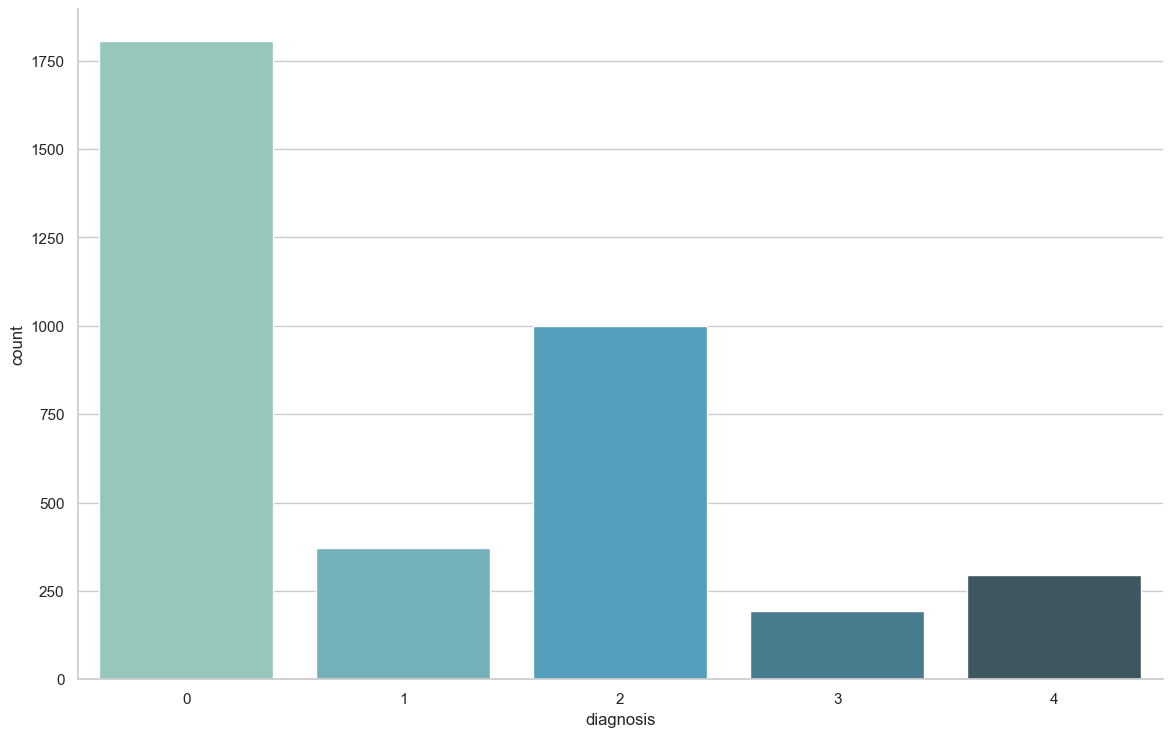

In [4]:
# Label Class Distribution
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

In [5]:
# Path specifications
KAGGLE_DIR = '../data/files/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TEST_DF_PATH = KAGGLE_DIR + 'test.csv'
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + 'test_images/'

In [6]:
# creating dataframes train and test
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)

# Add extension to id_code
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [7]:
# Setting the model parameters
BATCH_SIZE =32
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [8]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [9]:
# Data Generator for train, test and validation
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True
                                )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../data/images/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../data/images/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [10]:
from tensorflow.keras import applications
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def create_mobilenet_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.MobileNet(weights='imagenet', 
                                        include_top=False,
                                        input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model


In [11]:
mobilenet_model = create_mobilenet_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

# Freeze all layers and then unfreeze the last 5
for layer in mobilenet_model.layers:
    layer.trainable = False

for i in range(-5, 0):
    mobilenet_model.layers[i].trainable = True

# Learning rate warm-up
metric_list = ["accuracy"]
WARMUP_LEARNING_RATE = 1e-4
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)
mobilenet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metric_list)

mobilenet_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [12]:
# Train the top layers of the model
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=WARMUP_EPOCHS,
    verbose=1
).history

Epoch 1/2


91/91 [==============================] - 661s 7s/step - loss: 1.2117 - accuracy: 0.5959 - val_loss: 0.7285 - val_accuracy: 0.7287
Epoch 2/2
91/91 [==============================] - 651s 7s/step - loss: 0.9188 - accuracy: 0.6798 - val_loss: 0.6803 - val_accuracy: 0.7599


In [13]:
# Finetune the complete model
for layer in mobilenet_model.layers:
    layer.trainable = True
    
class MyThresholdCallback(Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs.get("val_accuracy")
        acc = logs.get("accuracy")
        if acc >= self.threshold and val_acc >= self.threshold:
            self.model.stop_training = True
            
my_callback = MyThresholdCallback(threshold=0.90)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)


callback_list = [rlrop, my_callback]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
mobilenet_model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

 conv_pw_1_relu (ReLU)       (None, 112, 112, 64)      0         
                                                                 
 conv_pad_2 (ZeroPadding2D)  (None, 113, 113, 64)      0         
                                                                 
 conv_dw_2 (DepthwiseConv2D  (None, 56, 56, 64)        576       
 )                                                               
                                                                 
 conv_dw_2_bn (BatchNormali  (None, 56, 56, 64)        256       
 zation)                                                         
                                                                 
 conv_dw_2_relu (ReLU)       (None, 56, 56, 64)        0         
                                                                 
 conv_pw_2 (Conv2D)          (None, 56, 56, 128)       8192      
                                                                 
 conv_pw_2_bn (BatchNormali  (None, 56, 56, 128)       512       
 zation)  

In [14]:
history_finetuning = mobilenet_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,
        epochs=50,
        callbacks=callback_list,
        verbose=1
    ).history


Epoch 1/50
91/91 [==============================] - 742s 8s/step - loss: 0.8532 - accuracy: 0.7043 - val_loss: 0.8428 - val_accuracy: 0.7585 - lr: 1.0000e-04
Epoch 2/50
91/91 [==============================] - 700s 8s/step - loss: 0.6308 - accuracy: 0.7688 - val_loss: 0.5953 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 3/50
91/91 [==============================] - 686s 8s/step - loss: 0.5327 - accuracy: 0.7985 - val_loss: 0.6207 - val_accuracy: 0.7784 - lr: 1.0000e-04
Epoch 4/50
91/91 [==============================] - 663s 7s/step - loss: 0.4662 - accuracy: 0.8290 - val_loss: 0.5783 - val_accuracy: 0.7940 - lr: 1.0000e-04
Epoch 5/50
91/91 [==============================] - 701s 8s/step - loss: 0.3874 - accuracy: 0.8561 - val_loss: 0.5744 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 6/50
91/91 [==============================] - 719s 8s/step - loss: 0.3399 - accuracy: 0.8785 - val_loss: 0.5483 - val_accuracy: 0.8054 - lr: 1.0000e-04
Epoch 7/50
91/91 [==============================] - 

In [15]:
mobilenet_model.save("../saved_models/final_model.h5")

In [16]:
loaded_model = load_model('../saved_models/final_model.h5')

In [17]:
# Model Evaluation
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../data/images/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = loaded_model.predict(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]
acc = np.sum(train['diagnosis'].astype('int') == train_preds) / 3662

Found 3662 validated image filenames.
3662/3662 [==============================] - 629s 171ms/step


In [18]:
print(f"Model Accuracy: {acc:.2f}")

Model Accuracy: 0.96


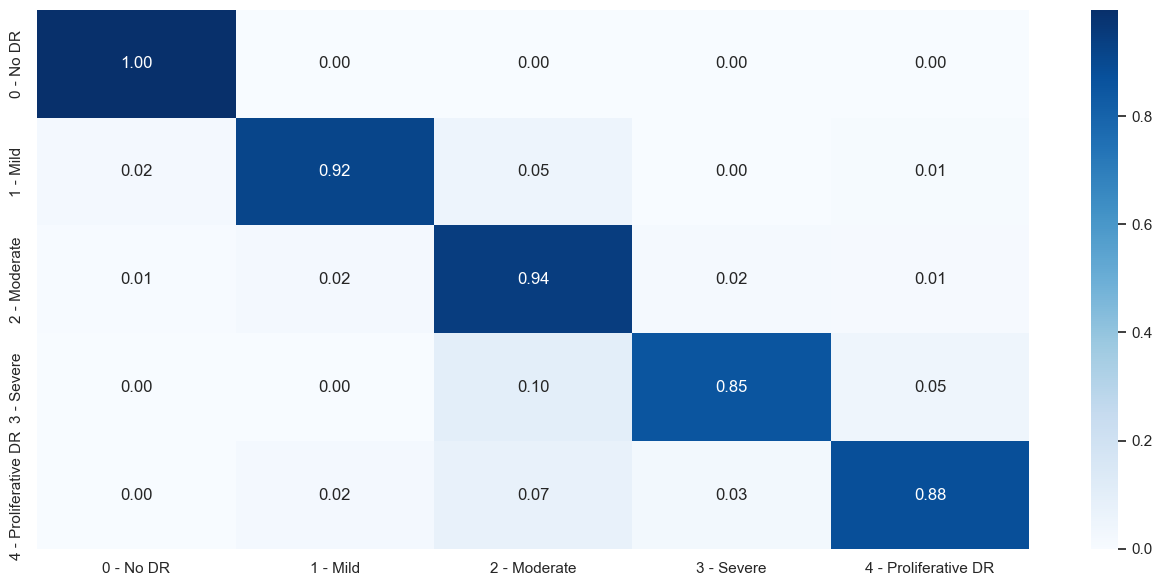

In [19]:
# Confusion Matrix
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()